<h2> <b>DeepSeek-VL: Towards Real-World Vision-Language Understanding</b></h2>

In [1]:
#https://arxiv.org/pdf/2403.05525


We present DeepSeek-VL, an open-source Vision-Language (VL) Model designed for real-world
vision and language understanding applications. Our approach is structured around three key
dimensions:<br><br>
**• Data Construction:** We strive to ensure our data is diverse, scalable and extensively covers
real-world scenarios including web screenshots, PDFs, OCR, charts, and knowledge-based
content (expert knowledge, textbooks), aiming for a comprehensive representation of practical
contexts. Further, we create a use case taxonomy from real user scenarios and construct an
instruction-tuning dataset accordingly. The fine-tuning with this dataset substantially improves
the model’s user experience in practical applications.<br><br>
**• Model Architecture:** Considering efficiency and the demands of most real-world scenarios,
DeepSeek-VL incorporates a hybrid vision encoder that efficiently processes high-resolution
images (1024 x 1024) within a fixed token budget, while maintaining a relatively low computational overhead. This design choice ensures the model’s ability to capture critical semantic and
detailed information across various visual tasks.<br><br>
**• Training Strategy:** We posit that a proficient Vision-Language Model should, foremost,
possess strong language abilities. To ensure the preservation of LLM capabilities during
pretraining, we investigate an effective VL pretraining strategy by integrating LLM training
from the beginning and carefully managing the competitive dynamics observed between vision
and language modalities. Starting with a focus on text, we gradually adjust the ratio to facilitate
a balanced integration of both modalities.<br><br>
The DeepSeek-VL family (both 1.3B and 7B models) showcases superior user experiences as a
vision-language chatbot in real-world applications, achieving state-of-the-art or competitive
performance across a wide range of visual-language benchmarks at the same model size while
maintaining robust performance on language-centric benchmarks. We have made both 1.3B
and 7B models publicly accessible to foster innovations based on this foundation model.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:

# High-resolution Encoder
def high_res_encoder(input_shape=(512, 512, 3)):  # Smaller resolution
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation="relu", strides=2)(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.GlobalAveragePooling2D()(x)  # Replace Flatten
    x = layers.Dense(256, activation="relu")(x)  # Reduce Dense size
    return models.Model(inputs, x)


# Low-resolution Encoder
def low_res_encoder(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation="relu", strides=2)(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    return models.Model(inputs, x)

In [5]:
# Vision-Language Adaptor (MLP)
def vision_language_adaptor():
    inputs = layers.Input(shape=(512,))
    x = layers.Dense(512, activation="relu")(inputs)
    x = layers.Dense(768, activation="relu")(x)
    return models.Model(inputs, x)


In [6]:
# Language model (placeholder for LLM integration)
def simple_language_model(vocab_size=5000, embedding_dim=512, max_len=100):
    inputs = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, embedding_dim)(inputs)
    x = layers.LSTM(512, return_sequences=False)(x)
    x = layers.Dense(512, activation="relu")(x)
    return models.Model(inputs, x)


In [7]:
# Combine Vision Encoder and Language Adaptor
def hybrid_multimodal_model():
    # Image Inputs

    high_res_input = layers.Input(shape=(512, 512, 3))
    low_res_input = layers.Input(shape=(128, 128, 3))

    #STEP1
    # Vision Encoding
    high_res_features = high_res_encoder()(high_res_input)
    low_res_features = low_res_encoder()(low_res_input)
    #we concatenate the highres and lowres
    combined_features = layers.Concatenate()([high_res_features, low_res_features])

    #STEP2 We feed the combined features
    # Vision-Language Adaptation
    adapted_features = vision_language_adaptor()(combined_features)

    #STEP3 we feed the text to the language model
    # Language Model Input (Dummy Text Input)
    text_input = layers.Input(shape=(100,))
    language_features = simple_language_model()(text_input)

    #STEP4 we pass it to a basic implementation of dense layer with 10 classification probabilities
    # Multimodal Fusion
    multimodal_output = layers.Concatenate()([adapted_features, language_features])
    final_output = layers.Dense(10, activation="softmax")(multimodal_output)  # For classification

    return models.Model(inputs=[high_res_input, low_res_input, text_input], outputs=final_output)

In [8]:
import numpy as np

In [9]:
# Compile the Model
model = hybrid_multimodal_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Dummy Dataset

images_high = np.random.rand(10, 512, 512, 3)
images_low = np.random.rand(10, 128, 128, 3)
texts = np.random.randint(0, 50, size=(10, 100))
labels = tf.keras.utils.to_categorical(np.random.randint(0, 10, size=(10,)), num_classes=10)

# Train
model.fit([images_high, images_low, texts], labels, batch_size=1, epochs=5)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0000e+00 - loss: 4.1220
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3234 - loss: 2.7501
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2241 - loss: 2.1181
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7936 - loss: 1.3904
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9322 - loss: 0.8914


In [10]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 256)            │          9,344 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 256)            │      7,873,664 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ functional[0][0],      │
│                           │                        │                │ functional_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 768)            │        656,640 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_3 (Functional) │ (None, 512)            │      4,921,856 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1280)           │              0 │ functional_2[0][0],    │
│ (Concatenate)             │                        │                │ functional_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 10)             │         12,810 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 40,422,944 (154.20 MB)

 Trainable params: 13,474,314 (51.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,948,630 (102.80 MB)

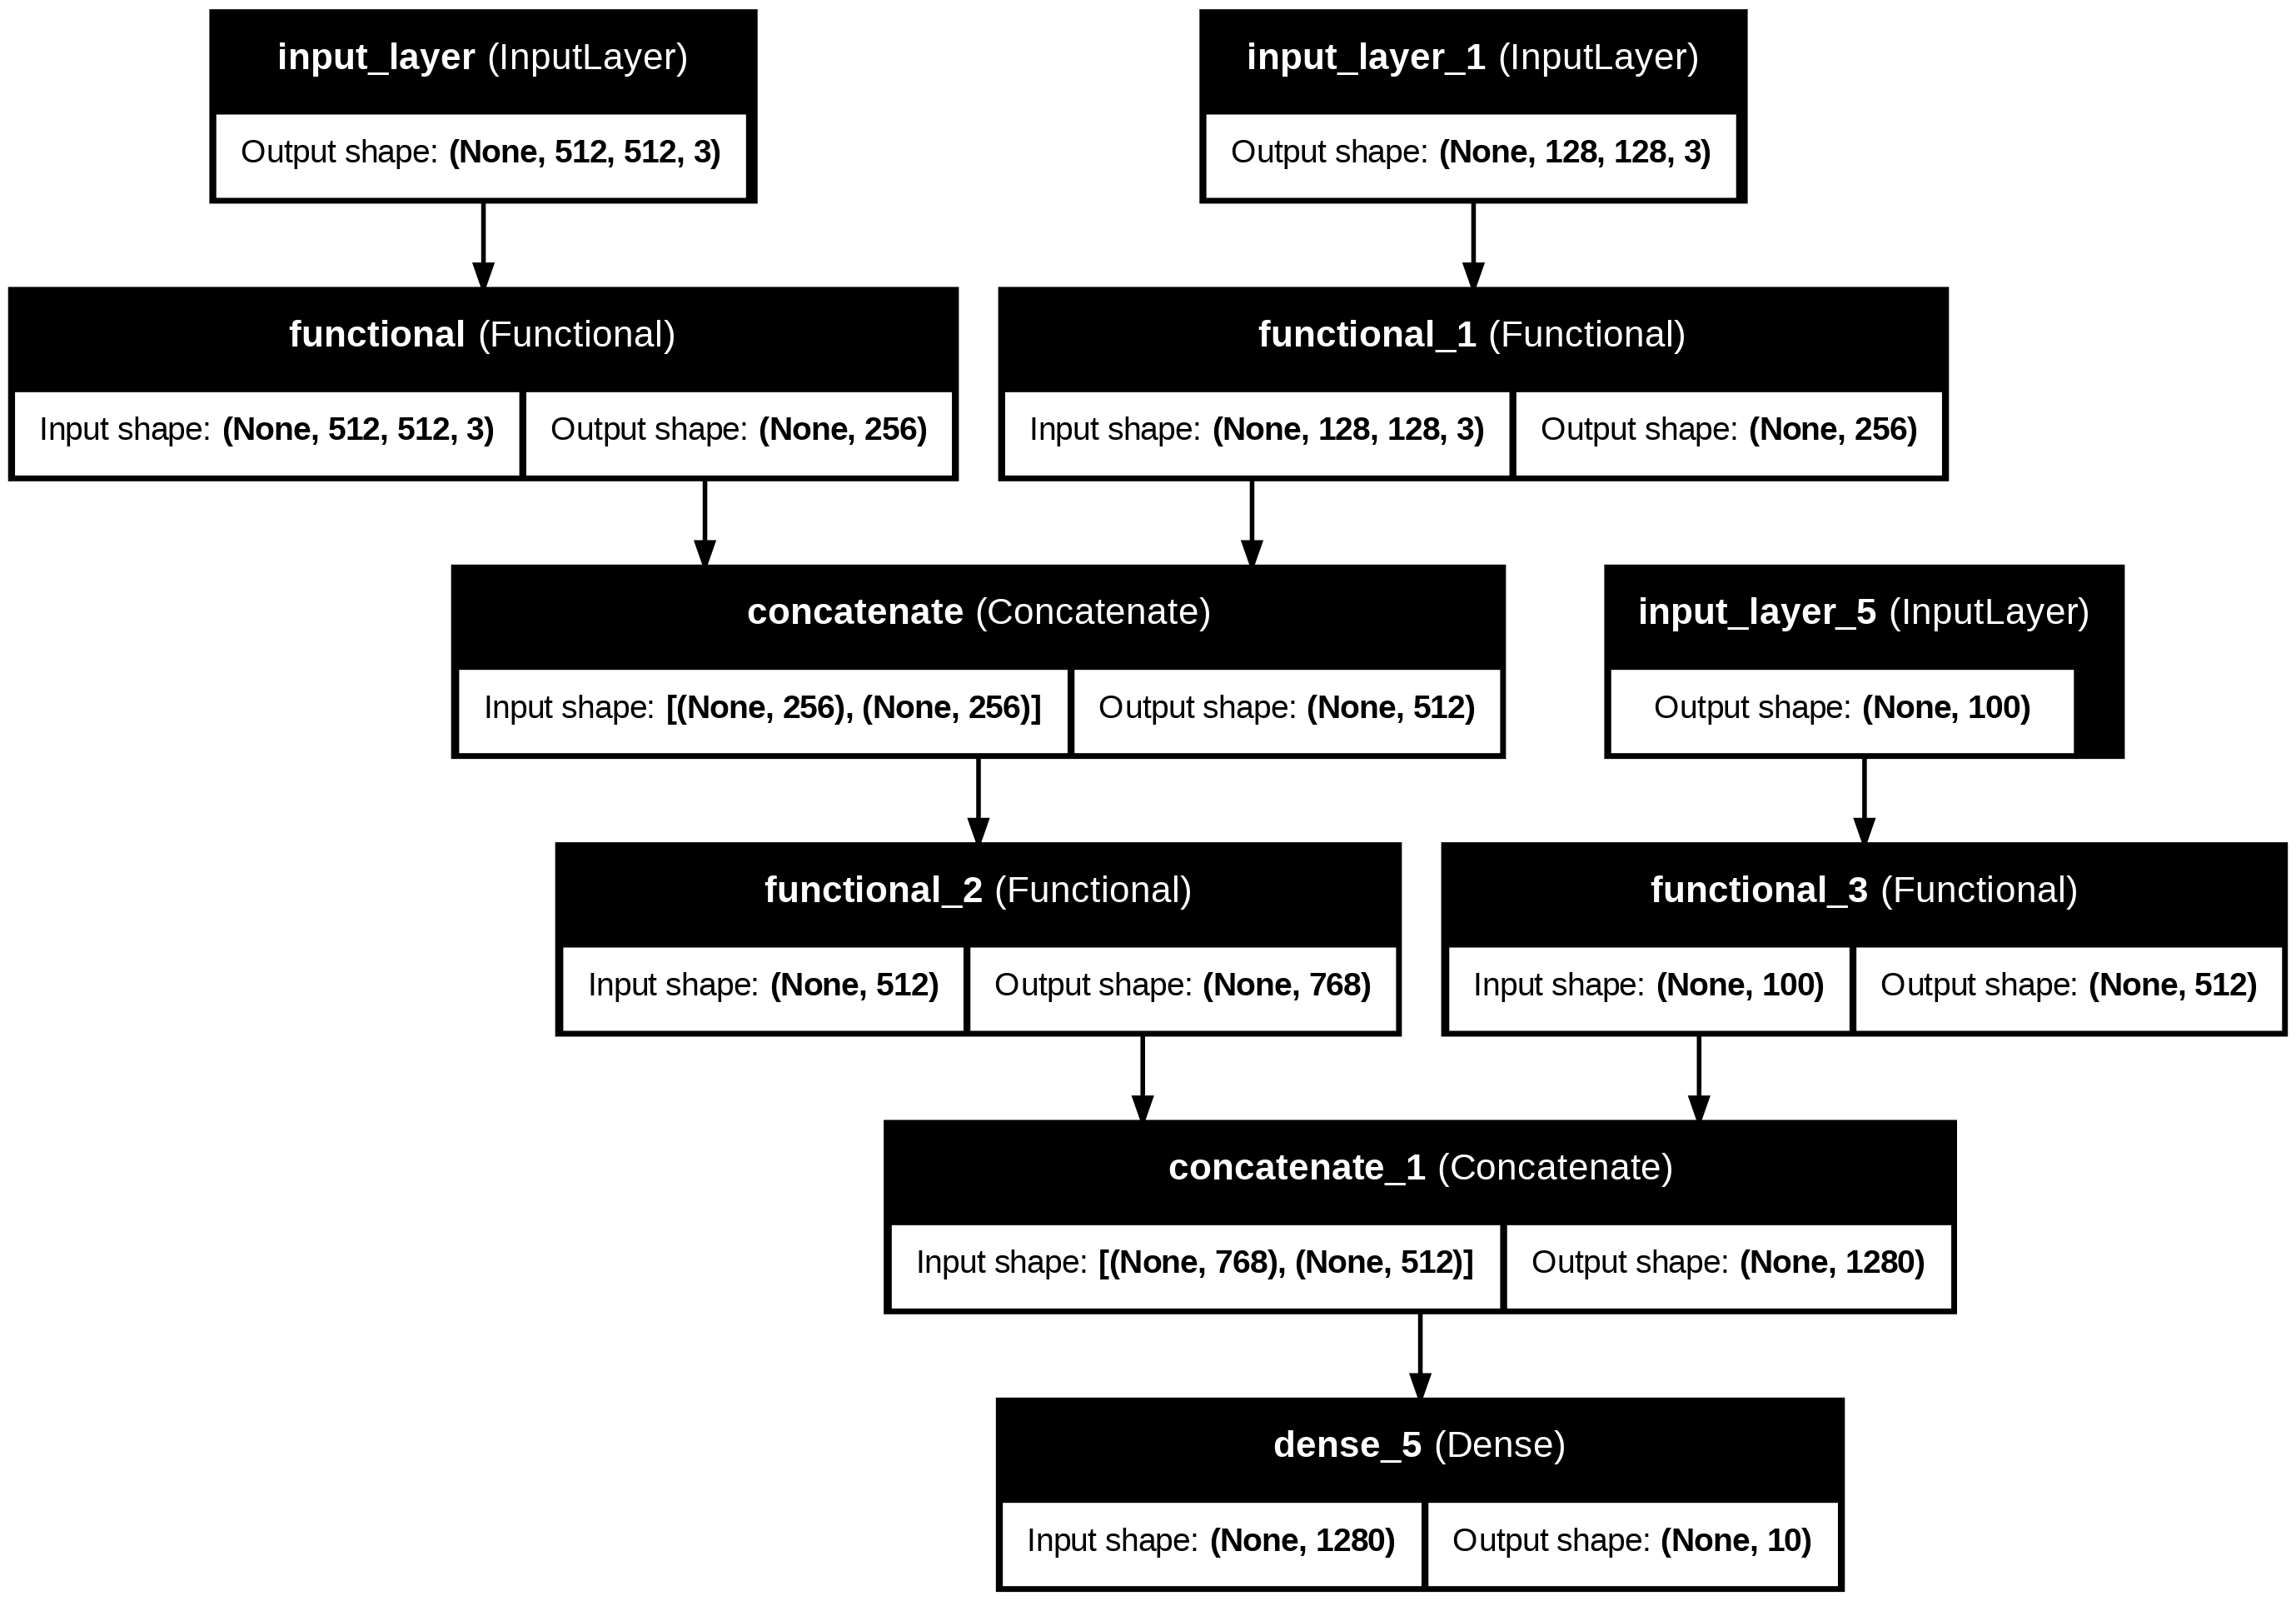

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Plot the model and save it as a temporary file
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

# Display the image
Image("model_architecture.png")


In [12]:
import numpy as np

# Prepare a single input
single_high_res = np.expand_dims(images_high[0], axis=0)  # Add batch dimension
single_low_res = np.expand_dims(images_low[0], axis=0)    # Add batch dimension
single_text = np.expand_dims(texts[0], axis=0)            # Add batch dimension

# Predict
predicted_output = model.predict([single_high_res, single_low_res, single_text])
print("Predicted Output:", predicted_output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Predicted Output: [[1.0412440e-04 1.4527168e-04 1.9309946e-03 1.7366096e-04 2.8396131e-02
  1.6049613e-03 2.7490195e-03 6.4137572e-01 2.5880577e-03 3.2093203e-01]]


In [13]:
predicted_output

array([[1.0412440e-04, 1.4527168e-04, 1.9309946e-03, 1.7366096e-04,
        2.8396131e-02, 1.6049613e-03, 2.7490195e-03, 6.4137572e-01,
        2.5880577e-03, 3.2093203e-01]], dtype=float32)

In [14]:
# Prepare evaluation dataset (can be the same as your training set for a test run)
test_images_high = images_high[:2]  # First 2 samples for testing
test_images_low = images_low[:2]
test_texts = texts[:2]
test_labels = labels[:2]

# Evaluate
loss, accuracy = model.evaluate([test_images_high, test_images_low, test_texts], test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 1.0000 - loss: 0.7100
Test Loss: 0.7100025415420532
Test Accuracy: 1.0
